In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
from PIL import Image
from tensorflow import keras
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd

In [16]:
for files in os.listdir(os.getcwd()):
    print(files)

.ipynb_checkpoints
CNN_model.ipynb
data_processing.ipynb
image registration.ipynb
metadata.csv
Patients_CT
Untitled1.ipynb


In [15]:
df = pd.read_csv('metadata.csv')
df

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2495,130,27,0,0,0,0,0,1,0
2496,130,28,0,0,0,0,0,1,0
2497,130,29,0,0,0,0,0,1,0
2498,130,30,0,0,0,0,0,1,0


In [50]:
df = df.set_index(["PatientNumber", "SliceNumber"])
df

Intraventricular  Intraparenchymal  Subarachnoid  \
PatientNumber SliceNumber                                                     
49            1                           0                 0             0   
              2                           0                 0             0   
              3                           0                 0             0   
              4                           0                 0             0   
              5                           0                 0             0   
...                                     ...               ...           ...   
130           27                          0                 0             0   
              28                          0                 0             0   
              29                          0                 0             0   
              30                          0                 0             0   
              31                          0                 0             0   

                           Epidural  Subdural  No_Hemorrhage  Fracture_Yes_No  
PatientNumber SliceNumber                                                      
49            1                   0         0              1                0  
              2                   0         0              1                0  
              3                   0         0              1                0  
              4                   0         0              1                0  
              5                   0         0              1                0  
...                             ...       ...            ...              ...  
130           27                  0         0              1                0  
              28                  0         0              1                0  
              29                  0         0              1                0  
              30                  0         0              1                0  
              31                  0         0              1                0  

[2500 rows x 7 columns]

In [71]:
def CheckDFAndReturnNumber(patientNumber, sliceNumber):
    
    y_val = 0
    
    if df.loc[(patientNumber, sliceNumber)]["Intraventricular"] == 1:
        y_val = 1
    elif df.loc[(patientNumber, sliceNumber)]["Intraparenchymal"] == 1:
        y_val = 2
    elif df.loc[(patientNumber, sliceNumber)]["Subarachnoid"] == 1:
        y_val = 3
    elif df.loc[(patientNumber, sliceNumber)]["Epidural"] == 1:
        y_val = 4
    elif df.loc[(patientNumber, sliceNumber)]["Subdural"] == 1:
        y_val = 5
        
    return y_val

In [53]:
df.loc[(66,6)]

Intraventricular    0
Intraparenchymal    0
Subarachnoid        0
Epidural            0
Subdural            0
No_Hemorrhage       1
Fracture_Yes_No     0
Name: (66, 6), dtype: int64

In [54]:
df.loc[(66,6)]["No_Hemorrhage"]

1

In [75]:
X = []
Y = []
count = 0
for patients in os.listdir("Patients_CT"):
    for images in os.listdir("Patients_CT/"+patients):
        if images[-4:] != ".jpg":
            continue
        patient_number = int(patients[1:])
        slice_number = int(images.split("_")[0])
        try:
            y_val = CheckDFAndReturnNumber(patient_number, slice_number)
        except KeyError:
            y_val = 0
        image = Image.open("Patients_CT/"+patients+"/"+images).convert("L")
        image = image.resize((256,256))
        image = np.array(image)
        X.append(image)
        Y.append(y_val)
        count+=1
        print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069


In [76]:
X = np.array(X)
Y = np.array(Y)

In [77]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, shuffle=True,
                                                                       random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2000, 256, 256), (2000, 1), (500, 256, 256), (500, 1))

In [79]:
unique, counts = np.unique(np.reshape(train_labels, (2000,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 1746, 1: 20, 2: 49, 3: 10, 4: 133, 5: 42}

In [80]:
unique, counts = np.unique(np.reshape(test_labels, (500,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 436, 1: 4, 2: 15, 3: 1, 4: 34, 5: 10}

In [81]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

In [82]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

In [83]:
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [84]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2000, 256, 256, 1) (2000, 6)
(500, 256, 256, 1) (500, 6)


In [85]:
N_BATCH = 50
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=2000).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint_cb = ModelCheckpoint("saved_model.h5", save_best_only=True)

patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [105]:
# callback
patience=20
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[256, 256, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(32, activation='relu'))

# output layer
cnn_model.add(keras.layers.Dense(6, activation='softmax'))

# model complie
cnn_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [94]:
# callback
patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[256, 256, 1]))
# pooling layer

cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer

cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer

cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(256, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.4))

# output layer
cnn_model.add(keras.layers.Dense(6, activation='softmax'))

# model complie
cnn_model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])

In [106]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      1600      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 128)      

In [107]:
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

40 10


In [108]:
istrue = os.path.exists("cnn_model.h2")

if not istrue:
    history = cnn_model.fit(train_dataset, 
                        epochs=50, steps_per_epoch=steps_per_epoch, callbacks=[early_stopping_cb], 
                        validation_data=test_dataset, validation_steps=validation_steps)
    cnn_model.save('cnn_model.h2')
    print("model is saved")
else:
    cnn_model = keras.models.load_model('cnn_model.h2')
    print("model is loaded")

Epoch 1/50
40/40 [==============================] - 4s 75ms/step - loss: 0.6131 - accuracy: 0.8730 - val_loss: 0.4407 - val_accuracy: 0.8720
Epoch 2/50
40/40 [==============================] - 3s 73ms/step - loss: 0.4115 - accuracy: 0.8800 - val_loss: 0.3903 - val_accuracy: 0.8520
Epoch 3/50
40/40 [==============================] - 3s 73ms/step - loss: 0.2689 - accuracy: 0.9060 - val_loss: 0.2511 - val_accuracy: 0.9160
Epoch 4/50
40/40 [==============================] - 3s 73ms/step - loss: 0.1745 - accuracy: 0.9365 - val_loss: 0.2200 - val_accuracy: 0.9180
Epoch 5/50
40/40 [==============================] - 3s 73ms/step - loss: 0.1306 - accuracy: 0.9510 - val_loss: 0.2065 - val_accuracy: 0.9260
Epoch 6/50
40/40 [==============================] - 3s 73ms/step - loss: 0.0928 - accuracy: 0.9690 - val_loss: 0.1698 - val_accuracy: 0.9520
Epoch 7/50
40/40 [==============================] - 3s 73ms/step - loss: 0.0818 - accuracy: 0.9725 - val_loss: 0.1810 - val_accuracy: 0.9420
Epoch 8/50
40

INFO:tensorflow:Assets written to: cnn_model.h2\assets


INFO:tensorflow:Assets written to: cnn_model.h2\assets


model is saved


In [109]:
cnn_model.evaluate(test_dataset)

10/10 [==============================] - 0s 35ms/step - loss: 0.1698 - accuracy: 0.9520


[0.16975745558738708, 0.9520000219345093]

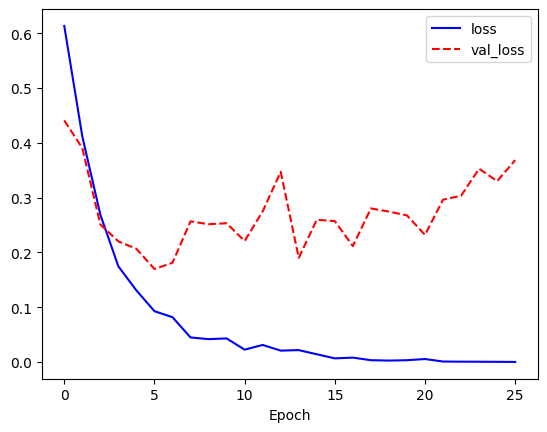

In [110]:
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

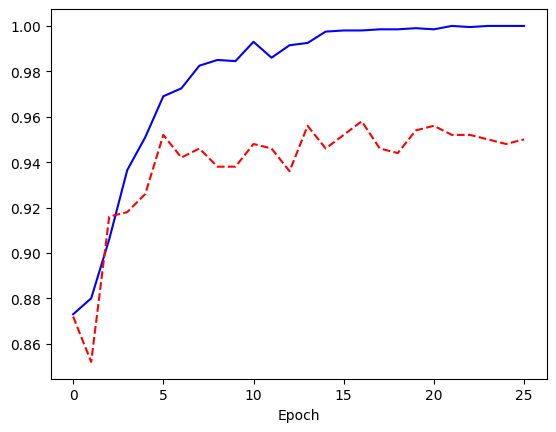

In [111]:
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend
plt.show()

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_onehot = cnn_model.predict(test_images)
y_pred = y_pred_onehot.argmax(axis=1)
y_actual = test_labels.argmax(axis=1)
cm_cnn = confusion_matrix(y_actual, y_pred)
cm_cnn

16/16 [==============================] - 1s 35ms/step


array([[425,   1,   4,   2,   3,   1],
       [  4,   0,   0,   0,   0,   0],
       [  3,   0,  11,   0,   0,   1],
       [  0,   0,   1,   0,   0,   0],
       [  3,   0,   0,   0,  30,   1],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

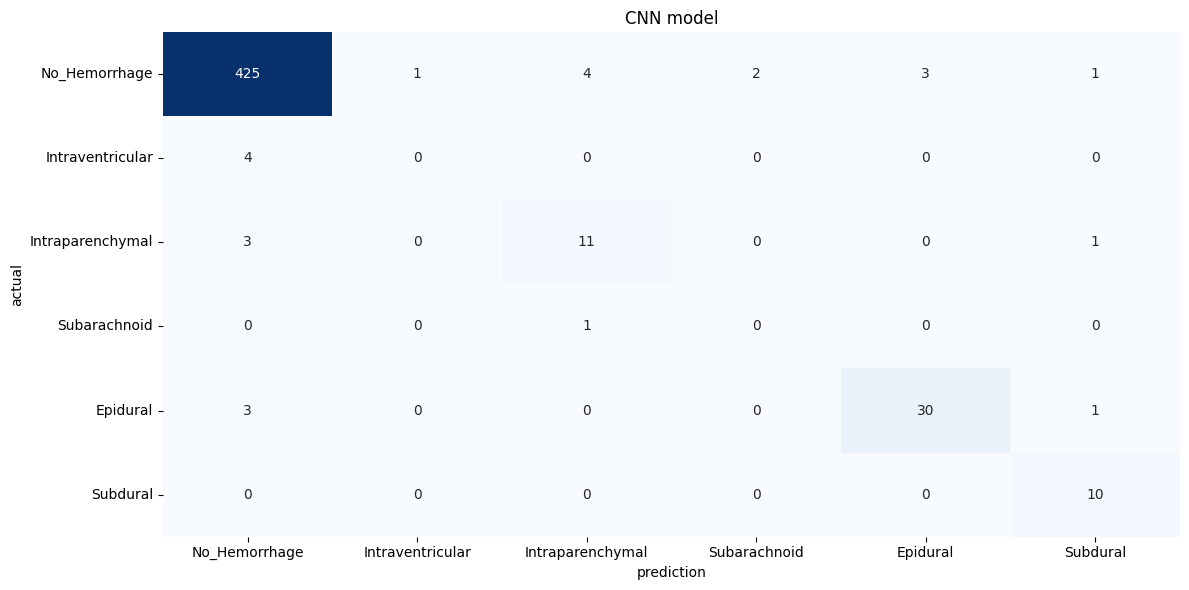

In [113]:
import seaborn as sns
plt.figure(figsize=(12,6), dpi=100)
class_names = ["No_Hemorrhage","Intraventricular", "Intraparenchymal", "Subarachnoid", "Epidural", "Subdural"]
sns.heatmap(cm_cnn, annot=True, fmt='.0f',
            cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)
plt.title("CNN model")
plt.xlabel("prediction")
plt.ylabel("actual")
plt.tight_layout()
plt.show()